# DNN

In [1]:
!pip install tensorflow==2.15.0

  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
^C
ERROR: Operation cancelled by user


In [2]:
!pip install keras==3.3.3

  Obtaining dependency information for keras==3.3.3 from https://files.pythonhosted.org/packages/8d/44/c604ecc5c9993b6574a681f2f505e980725871a89cfd9e48597b12ccb506/keras-3.3.3-py3-none-any.whl.metadata
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
np.random.seed(11)

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.models import load_model

2024-05-13 20:14:26.766090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 20:14:27.142244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 20:14:27.142420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 20:14:27.173283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 20:14:27.254373: I tensorflow/core/platform/cpu_feature_guar

In [4]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
accelerate                   0.29.3
adjustText                   0.8
aiohttp                      3.9.5
aiosignal                    1.3.1
altair                       5.3.0
annotated-types              0.6.0
anyio                        4.0.0
appnope                      0.1.3
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.3
attrs                        23.1.0
awscrt                       0.20.9
Babel                        2.13.0
backcall                     0.2.0
backoff                      2.2.1
beautifulsoup4               4.12.2
bleach                       6.1.0
blinker                      1.7.0
boto3                        1.34.101
botocore                     1.34.101


# Cargar Datos

In [5]:
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

In [6]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [7]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [8]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [9]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

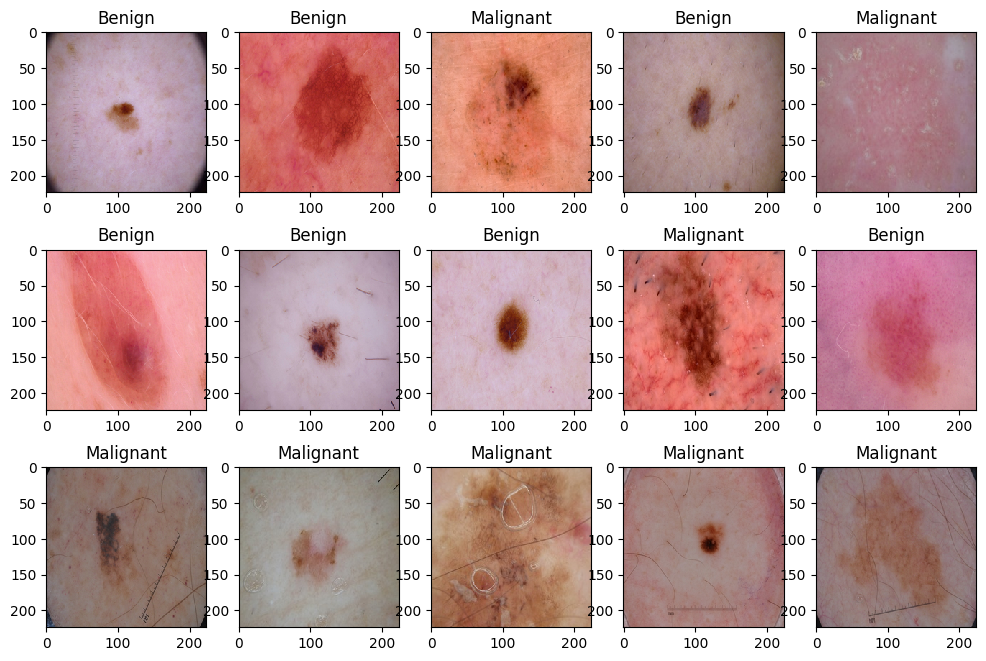

In [10]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Convertir etiquetas a cetegóricas

In [11]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalizar

In [12]:
X_train = X_train/255.
X_test = X_test/255.

# Construir el modelo

In [13]:
input_shape = (224, 224, 3)  # Actualiza este valor según el tamaño real de tus imágenes

# Creando el modelo de la red neuronal
model = Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=input_shape))
model.add(layers.Flatten())  # Flatten the 3D feature maps to 1D
model.add(layers.Dense(2, activation='sigmoid'))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-13 20:14:39.256437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 20:14:39.435038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/test

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1605632)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │     3,211,266 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,211,394 (12.25 MB)

 Trainable params: 3,211,394 (12.25 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Cambio en la función de pérdida para clasificación binaria
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 25,
                    batch_size=20,
                    verbose=1,
                   )

Epoch 1/25


2024-05-13 20:14:44.441025: I external/local_xla/xla/service/service.cc:168] XLA service 0xddb46e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 20:14:44.441073: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-13 20:14:44.501299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 20:14:44.710566: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


  8/106 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4138 - loss: 27.0201

I0000 00:00:1715631287.518189    3667 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5954 - loss: 10.4453 - val_accuracy: 0.7064 - val_loss: 1.3873
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7383 - loss: 1.5107 - val_accuracy: 0.7557 - val_loss: 0.8593
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7653 - loss: 1.1396 - val_accuracy: 0.5985 - val_loss: 2.0353
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7604 - loss: 1.2082 - val_accuracy: 0.7064 - val_loss: 0.9692
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7855 - loss: 0.7063 - val_accuracy: 0.7633 - val_loss: 0.6341
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8466 - loss: 0.3295 - val_accuracy: 0.8220 - val_loss: 0.5858
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8636 - loss: 0.3529 - val_accuracy: 0.8201 - val_loss: 0.4543
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8789 - loss: 0.2682 - val_accuracy: 0.8

In [17]:
# guardar modelo
if not os.path.exists('models'):
    print('No existe la carpeta')
    os.mkdir('models')

model.save('models/dnn_2.h5')

In [18]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


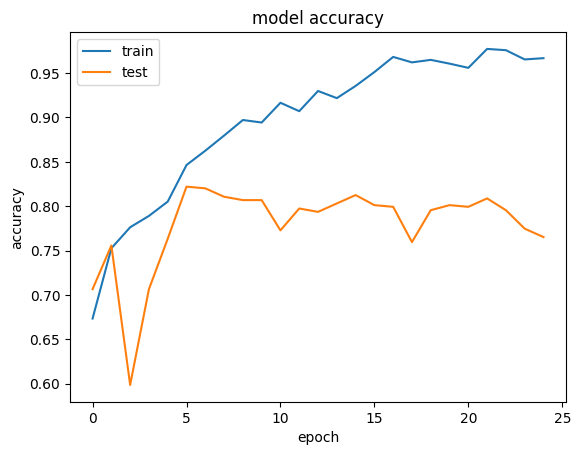

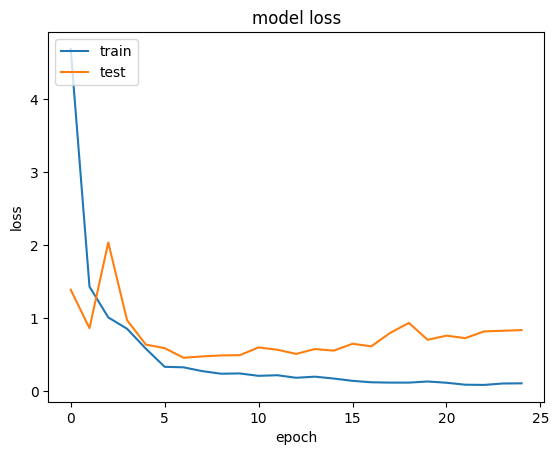

<Figure size 640x480 with 0 Axes>

In [19]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/dnn-acc-2.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/dnn-loss-2.png')

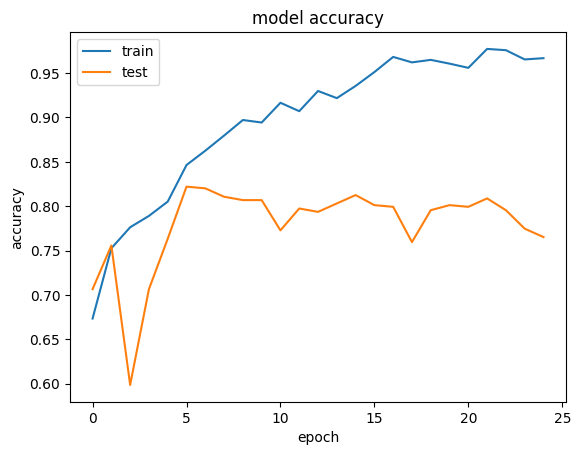

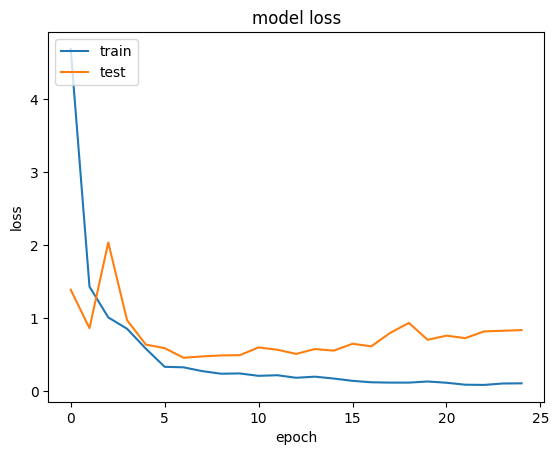

<Figure size 640x480 with 0 Axes>

In [20]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/dnn-acc-2.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/dnn-loss-2.png')

# Predicciones

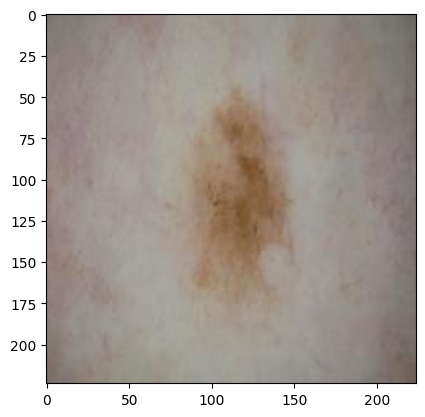

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
[[0.26239952 0.66725785]]
Maligno


In [22]:
# cargar modelo
model = load_model('models/dnn.h5')

# cargar imagen
img = Image.open('data/test/malignant/13.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')

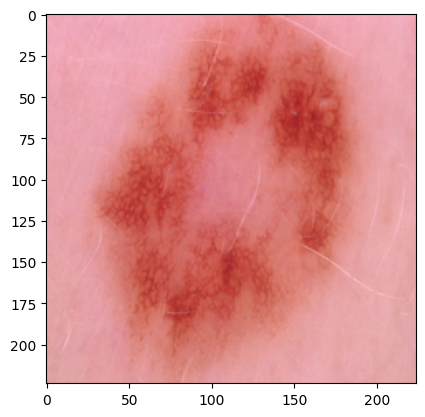

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[0.99388593 0.00707015]]
Benigno


In [23]:
# cargar modelo
model = load_model('models/dnn.h5')

# cargar imagen
img = Image.open('data/test/benign/63.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')